# DBSCAN: Density-Based Spatial Clustering of Applications With Noise

This notebook implements the DBSCAN (density-based spatial clustering of applications with noise) algorithm, an unsupervised learning method. It is a clustering algorithm that groups together data points that are closely packed together in high-density regions, while marking outliers or noise points that lie in low-density regions. Since it is a density-based clustering algorithm, it clusters data points based on their density, rather than their distance from a centroid.

Compared to *k*-means clustering, which is a centroid-based clustering algorithm, DBSCAN has several advantages. Firstly, it does not require a pre-defined number of clusters, and can find clusters of any shape and size, whereas *k*-means requires the number of clusters to be specified beforehand. DBSCAN can also handle noise and outliers effectively, since they are not assigned to any cluster, while *k*-means clustering treats outliers as their own cluster, which can distort the results. Finally, DBSCAN is less sensitive to the initial placement of centroids than *k*-means clustering, as it does not use centroids to define the clusters.

For more details about the algorithm, check out the README of this subdirectory, [here](https://github.com/kary5678/INDE-577/blob/main/unsupervised-learning/dbscan/README.md).

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the Seaborn theme
sns.set_theme()

# Import functions from scikit-learn to help with modeling endeavors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix

## The Data

The model will be trained using the [Hawks](https://r-data.pmagunia.com/dataset/r-dataset-package-stat2data-hawks) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


## Using scikit-learn

I will be first be using `DBSCAN` from the scikit-learn library to understand how this algorithm works.

### Data preparation - wing & tail length

Because I want to plot the results of DBSCAN in the 2D space, I am going to just use 2 predictors. Since DBSCAN is an unsupervised learning algorithm that does not require labeled data to learn, the data does not need to be separated the data into a training/testing set.

In [3]:
# Data preparation step
X = hawks[["Wing", "Tail"]]
y = hawks["Species"]

Because DBSCAN is a density-based clustering algorithm that depends on the notion of distance between data points, it is a good practice to standardize the data to ensure that the results are not biased by the scale of the input features. Standardizing the data ensures that all features are on the same scale, which can prevent features with larger values from dominating the distance metric.

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Choose the optimal epsilon and min_samples parameters

Before implementing DBSCAN, the optimal $\epsilon$ (the maximum distance between two samples for one to be considered as in the neighborhood of the other) and min_samples (minimum number of points required to form a dense region) needs to be determined. One way to evaluate this is by obtaining the silhouette score for each combination of $\epsilon$ and min_samples. 

The silhouette score is a metric that measures the coherence of each cluster, which is based on the average distance between the data points within a cluster and the average distance between the data points in the nearest neighboring cluster. The silhouette score ranges from -1 to 1, where a value closer to 1 indicates a better clustering. I will plot the silhouette score the combinations of $\epsilon$ and min_samples and determine the optimal value for these parameters by inspection of the curves; this plot is also known as the elbow method plot.

In [5]:
def plot_elbow_method(X):
    """
    A diagnostic plot to determine the number of clusters, k, in a data set. 
    We want to minimize inertia and select the value of k at the "elbow" of the plot.
    Beyond the elbow, the cost of computation does not outweigh the perfomance gain.
    """
    epsilons = np.arange(0.2, 1, 0.2)
    possible_n = range(2, 11)
    scores = []
    for e in epsilons:
        current_scores = []
        for n in possible_n:
            db_model = DBSCAN(eps = e, min_samples = n)
            db_model.fit(X)
            current_scores.append(silhouette_score(X, db_model.labels_))
        scores.append(current_scores)
    
    plt.figure(figsize = (7, 5))
    plt.plot(possible_n, scores[0], color = 'red', marker = "o", label="0.2")
    plt.plot(possible_n, scores[1], color = 'gold', marker = "o", label="0.4")
    plt.plot(possible_n, scores[2], color = 'blue', marker = "o", label="0.6")
    plt.plot(possible_n, scores[3], color = 'green', marker = "o", label="0.8")
    plt.legend(title = "Epsilon", loc = "best")
    plt.xlabel("min_samples", fontsize = 12)
    plt.ylabel("Silhouette score", fontsize = 12)
    plt.xticks(possible_n)

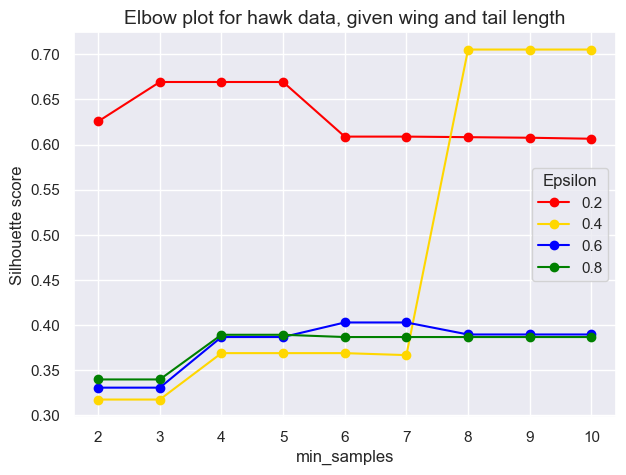

In [6]:
plot_elbow_method(X_scaled)
plt.title("Elbow plot for hawk data, given wing and tail length", fontsize = 14)
plt.show()

Setting a high value for min_samples in DBSCAN can result in fewer clusters being formed, as the algorithm requires a minimum number of points to be close to each other to form a dense region. A lower value of min_samples allows for more flexibility in forming clusters and can result in more clusters being formed. Based on this fact, I will proceed with `eps=0.2` and `min_samples=3`, as this combination maximizes the silhouette score while not having the value for the min_samples parameter be too high.


### DBSCAN with `eps=0.2`, `min_samples=3`

In [7]:
db_model = DBSCAN(eps = 0.2, min_samples = 3)
db_model.fit(X_scaled)

db_labels = db_model.fit_predict(X_scaled)
print("Silhouette score:", silhouette_score(X_scaled, db_labels))

Silhouette score: 0.6693351227002977


To understand the clustering results, I will plot the results of DBSCAN.

In [8]:
def plot_dbscan_clusters(X, model):
    """
    Evaluate the clustering results by plotting them on a scatter plot
    """
    db_labels = model.fit_predict(X)
    plt.figure(figsize = (7, 5))
    scatter = plt.scatter(X_scaled[:,0], X_scaled[:,1], c = db_labels, cmap = "viridis")
    handles, legend_labels = scatter.legend_elements()
    plt.legend(handles, legend_labels)
    plt.title(f"Hawk DBSCAN Clustering Results (eps={model.get_params()['eps']}, min_samples={model.get_params()['min_samples']})",
            fontsize = 14)
    plt.xlabel("Standardized wing length")
    plt.ylabel("Standardized tail length")

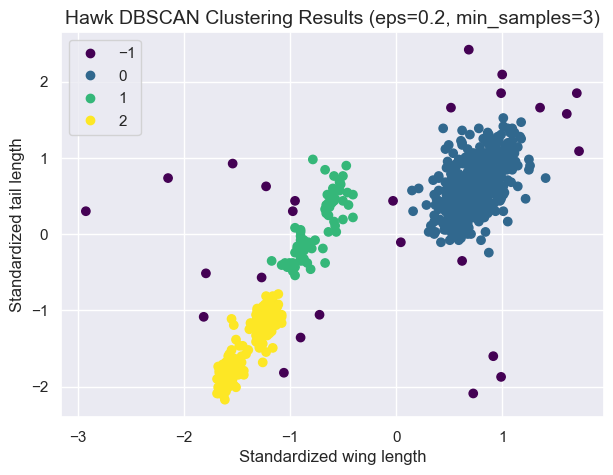

In [9]:
plot_dbscan_clusters(X_scaled, db_model)

Noise is denoted by `-1`, and DBSCAN recognized these points as being far away from the main cluster. Since I know the true labels for each hawk, I can use this to my advantage to understand whether what is happening.

Let's refer back to the original data. Specifically, let's look at the true classifications with noisy observations removed in one panel, and emphasized in the other.

In [10]:
def plot_hawk_noise(X, y, db_labels):
    """
    Plot the DBSCAN results for the hawk data. Produces two panels, one removes the noise while the 
    other emphasizes the noise points to understand which hawks are considered to be noise.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle("Scatterplot of Hawk Species by Tail vs. Wing Length", fontsize = 15)
    species_colors = {"RT": 0, "CH": 1, "SS": 2}

    # Plot the data points by species, excluding those determined to be noise by DBSCAN
    X_cleaned = X[db_labels != -1]
    y_cleaned = y[db_labels != -1]
    ax1.set_xlim((0, 500))
    ax1.set_ylim((115, 280))
    scatter1 = ax1.scatter(X_cleaned["Wing"], X_cleaned["Tail"], c = [species_colors[hawk] for hawk in y_cleaned], cmap = "viridis") 
    ax1.legend(handles = scatter1.legend_elements()[0], labels = species_colors.keys(), fontsize = 11, loc = "upper left")
    ax1.set_xlabel("Wing length [mm]")
    ax1.set_ylabel("Tail length [mm]")
    ax1.set_title("Hawks by DBSCAN Clusters, noise removed", fontsize = 13)

    # Plot all data points by species, emphasizing those determined to be noise by DBSCAN
    ax2.set_xlim((0, 500))
    ax2.set_ylim((115, 280))
    scatter2 = ax2.scatter(X["Wing"], X["Tail"], c = [species_colors[hawk] for hawk in y], cmap = "viridis")
    ax2.scatter(X["Wing"][db_labels == -1], X["Tail"][db_labels == -1],
                c = [species_colors[hawk] for hawk in y[db_labels == -1]], cmap = "viridis", edgecolors = "white", s = 300)
    ax2.set_xlabel("Wing length [mm]")
    ax2.set_ylabel("Tail length [mm]")
    ax2.set_title("Hawks by DBSCAN Clusters, noise emphasized", fontsize = 13)
    ax2.legend(handles = scatter2.legend_elements()[0], labels = species_colors.keys(), fontsize = 11, loc = "upper left")

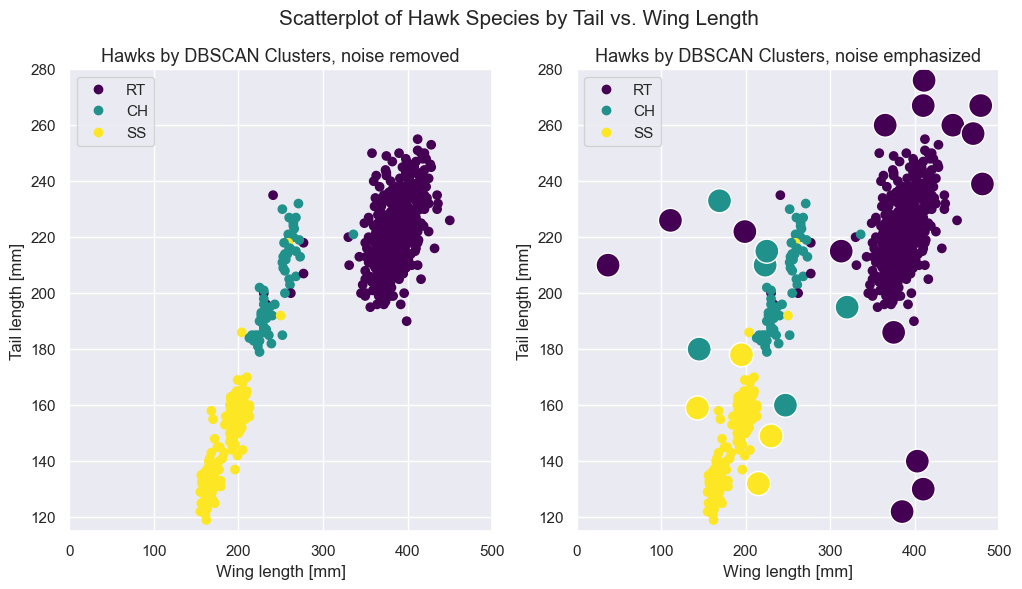

In [11]:
plot_hawk_noise(X, y, db_labels)

For the most part DBSCAN successfully removed points that deviated far from a cluster and would be difficult to classify correctly, as seen in supervised learning classification tasks. Something I'm curious about is the classification accuracy after removing noisy observations. Note that in unsupervised learning, you don't have labels for the data, so this isn't something you can normally check, but I am able to for my dataset.

In [12]:
# Map the non-noisy DBSCAN labels to their species and print the classification report
species_nums = {0: "RT", 1: "CH", 2: "SS"}
y_pred = np.array(list(map(lambda i : species_nums[i], db_labels[db_labels != -1])))

print(classification_report(y[db_labels != -1], y_pred))

              precision    recall  f1-score   support

          CH       0.86      0.94      0.89        63
          RT       0.99      0.99      0.99       551
          SS       0.99      0.98      0.99       251

    accuracy                           0.98       865
   macro avg       0.95      0.97      0.96       865
weighted avg       0.98      0.98      0.98       865



After removing noise, I see that accuracy, precision, and recall are all high. These metrics are higher than what I've seen across my other notebooks. Of course, these values are inflated due to the removal of the noisy observations in this analysis; in the other notebooks, these observations are typically misclassified and drag down the score.

For fun, I can also look at the confusion matrix.

In [13]:
def plot_hawk_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    # Obtain confusion matrix
    classes = ["RT", "CH", "SS"]
    cf_matrix = confusion_matrix(y_actual, y_pred, labels = classes)

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Hawk Species Confusion Matrix', fontsize = 14)
    ax.set_xlabel("Predicted Label", fontsize = 12)
    ax.set_xticklabels(classes)
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_yticklabels(classes, rotation = 0)

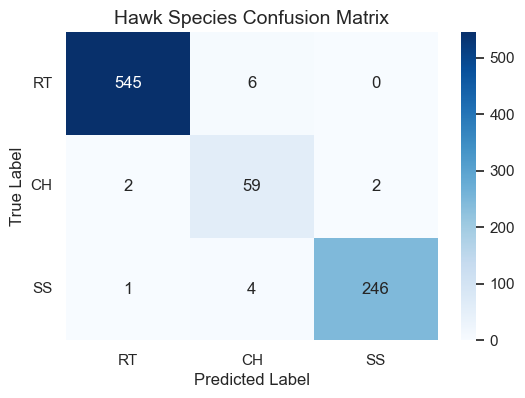

In [14]:
plot_hawk_confusion_matrix(y[db_labels != -1], y_pred)

Pretty typical confusion matrix distribution based on my confusion matrices from other algorithms. 

One thing to note is that noisy observations are not considered in analysis, meaning relevant hawks are just labeled as noise and not classified as a species. If such a classification had to be made for such observations, DBSCAN doesn't necessarily have a way to do so - at least in other algorithms such as decision trees where there are decision boundaries, a best guess is made with regard to a hawk species.

### DBSCAN with `eps=0.4`, `min_samples=8`

Setting a very low value for min_samples can lead to overfitting and noise being assigned to its own clusters. Keeping this in mind, I also will try DBSCAN with `eps=0.4` and `min_samples=8`, because this combination also produces a high silhouette score per the elbow plot.

In [15]:
db_model2 = DBSCAN(eps = 0.4, min_samples = 8)
db_model2.fit(X_scaled)

db_labels2 = db_model2.fit_predict(X_scaled)
print("Silhouette score:", silhouette_score(X_scaled, db_labels2))

Silhouette score: 0.7052903891368555


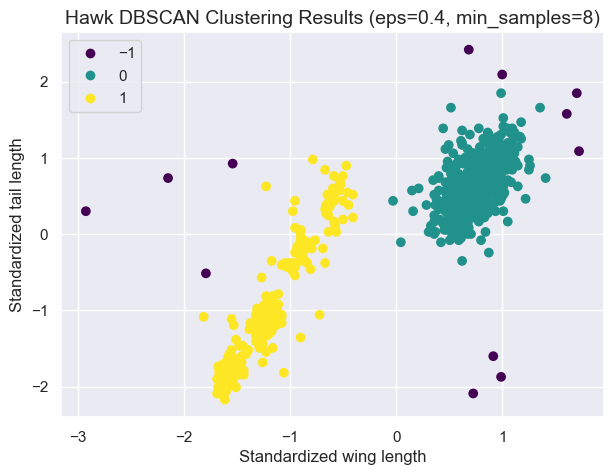

In [16]:
plot_dbscan_clusters(X_scaled, db_model2)

Plotting the results for this DBSCAN model, I am unsatisfied with the results. I know that there are 3 different species of hawks in the data, but DBSCAN under this parameterization only identified two clusters, as confirmed below:

In [17]:
np.unique(db_labels2, return_counts = True)

(array([-1,  0,  1]), array([ 12, 554, 325]))

There are 12 noisy points, and 554 hawks in one cluster and 325 hawks in another cluster. Perhaps for binary classification of red-tailed vs. not red-tailed hawks, this DBSCAN model would be acceptable, but for the 3 species version, the previous model using `eps=0.2` and `min_samples=3` does better for the hawks data.

Finally, a disclaimer. It is important to note that **in unsupervised learning, you don't have labels for the data**. Because I knew what hawk species each observation was, I could tell that using `eps=0.2` and `min_samples=3` would produce the best DBSCAN model. In reality, one might have to proceed with the `eps=0.4` and `min_samples=8` parameterization without any further information about the data, as this is what produced the highest silhouette score.

## Implementing DBSCAN: a custom class

Now I will implement DBSCAN from scratch, creating this custom class with all the necessary functionalities outlined by the algorithm, found in the `README.md` file of this dbscan directory.

In [18]:
class MyDBSCAN:
    """
    A custom class that implements the DBSCAN algorithm to cluster data points based on their density.
    ...

    Attributes
    ----------
    epsilon: float, the maximum distance between two points for them to be considered as in the same neighborhood
    min_samples: int, the minimum number of samples in a neighborhood for a point to be considered as a core point
    self.current_cluster: int, the current cluster number
    self.container: list of lists, a container of [x, flag, cluster] values 
        x: 1D array containing the coordinates of a data point
        flag: int, 0 if the point has not been visited, 1 if the point has been visited
        cluster: int, the cluster number of the point
    """

    def __init__(self, epsilon, min_samples):
        self.epsilon = epsilon
        self.min_samples = min_samples
        self.current_cluster = 1
        self.container = None

    def fit(self, X):
        """
        Implements the DBSCAN algorithm to cluster the data points in X,
        storing the results in a container of [x, flag, cluster] values.

        X: array containing the data points to be clustered
        """
        container = [[x, 0, 0] for x in X]
        for index in range(len(container)):
            if container[index][1] == 0:
                self.expand_cluster(container[index], container)
                self.current_cluster += 1
        self.container = container
        #return np.array([x[0] for x in container]), np.array([x[1] for x in container]), np.array([x[2] for x in container])

    def expand_cluster(self, x, container):
        """
        Helper function to expand a cluster around a core point by finding all
        points within epsilon distance.

        x: 1D array containing the coordinates of the core point
        container: list of lists, a container of [x, flag, cluster] values
        """
        neighbors = self.get_neighbors(x, container)
        if len(neighbors) < self.min_samples: # case when x is noise
            x[1] = 1 # mark as visited
            x[2] = -1
            return False
        else:
            x[2] = self.current_cluster
            for index in neighbors:
                container[index][2] = self.current_cluster
                if container[index][1] != 1:
                    container[index][1] = 1 # mark as visited
                    new_neighbors = self.get_neighbors(container[index], container)
                    if len(new_neighbors) >= self.min_samples:
                        for new_index in new_neighbors:
                            self.expand_cluster(container[new_index], container)
            return True
    
    def get_neighbors(self, x, container):
        """
        Helper function to get the neighbors of a point within a given distance epsilon

        x: 1D array containing the coordinates of the point
        container: list of lists, a container of [x, flag, cluster] values
        """
        neighbors = []
        for index, y in enumerate(container):
            if self.dist(x[0], y[0]) <= self.epsilon:
                neighbors.append(index)
        return neighbors
    
    def dist(self, x, y):
        """
        Helper function to calculate the Euclidean distance between two points x and y
        """
        return np.sqrt((x - y) @ (x - y))
    
    def retrieve_data(self):
        """
        Returns the data points in the container, which are the original data used to fit the model
        """
        return np.array([x[0] for x in self.container])

    def get_labels(self):
        """
        Returns the cluster labels of the data points in the container
        Cluster values are positive integers, while -1 denotes noise
        """
        return [x[2] for x in self.container]
    
    def plot_clusters(self):
        """
        Create a scatter plot of the data points, colored by their cluster labels
        """
        data = self.retrieve_data()
        plt.figure(figsize = (7, 5))
        scatter = plt.scatter(data[:,0], data[:,1], c = self.get_labels(), s = 50, cmap = "viridis")
        handles, legend_labels = scatter.legend_elements()
        plt.legend(handles, legend_labels)
        plt.title(f"DBSCAN Clustering Results (eps={self.epsilon}, min_samples={self.min_samples})",
                    fontsize = 14)
        plt.xlabel("Standardized x0")
        plt.ylabel("Standardized x1")


From my previous analysis, I know that good hyperparameter values are `epsilon = 0.2` and `min_samples = 3`, so I will proceed with these values to see if I get the same results.

In [19]:
my_dbscan = MyDBSCAN(epsilon = 0.2, min_samples = 3)
my_dbscan.fit(X_scaled)

Let's look at the some results of the fitted DBSCAN model. All the information is stored in the `container` attribute, which consists of elements of `[x, flag, cluster]`.

In [20]:
my_dbscan.container[0:5]

[[array([0.72486048, 0.54628708]), 1, 1],
 [array([0.68287155, 0.98099926]), 1, 1],
 [array([-0.53480754,  0.57345659]), 1, 2],
 [array([-1.16464155, -1.1382226 ]), 1, 3],
 [array([1.00828579, 0.8451517 ]), 1, 1]]

The first element is the data point, while the last is the cluster it's assigned to. The middle element is a flag for whether the data point was visited or not; all points need to be visited for DBSCAN to terminate.

In [21]:
visited = [x[1] for x in my_dbscan.container]
print(f"{sum(visited)} of {len(visited)} points have been visited.")

891 of 891 points have been visited.


Let's play with the `get_neighbors()` function, which finds the index of data points within epsilon distance to the point.

In [22]:
neighbors = my_dbscan.get_neighbors(my_dbscan.container[0][0], my_dbscan.container)
print(len(neighbors), neighbors)

146 [0, 9, 16, 17, 18, 39, 40, 42, 43, 44, 45, 59, 69, 73, 84, 86, 87, 99, 100, 104, 109, 111, 112, 113, 117, 125, 129, 130, 131, 133, 140, 143, 150, 157, 159, 172, 174, 175, 177, 178, 179, 186, 190, 200, 203, 215, 228, 232, 233, 239, 252, 257, 261, 264, 269, 276, 283, 286, 288, 312, 325, 339, 340, 343, 353, 355, 366, 367, 374, 377, 379, 380, 405, 409, 412, 413, 420, 431, 435, 440, 441, 450, 453, 456, 463, 464, 481, 483, 486, 489, 490, 491, 493, 502, 507, 514, 517, 535, 537, 539, 547, 549, 554, 555, 569, 572, 574, 589, 593, 597, 615, 624, 628, 647, 649, 655, 684, 688, 698, 699, 706, 709, 711, 716, 726, 728, 743, 753, 757, 768, 770, 787, 794, 795, 799, 806, 807, 810, 828, 829, 830, 836, 839, 845, 849, 886]


There are 146 neighbors within epsilon distance to the point [0.72486048, 0.54628708], which was assigned to cluster 1. These 146 neighbors may or may not be assigned to cluster 1 as well. Let's look at the total number of data points assigned to each cluster.

In [23]:
unique, counts = np.unique(my_dbscan.get_labels(), return_counts = True)
print(dict(zip(unique, counts)))

{-1: 26, 1: 548, 2: 69, 3: 248}


There are 3 clusters and 26 points classified as noise, supported by the output below (which is inflated by 1 because it's incremented prior to terminating with no more data points to expand clusters for).

In [24]:
my_dbscan.current_cluster

30

Moment of truth... time to plot the results and see if they make sense.

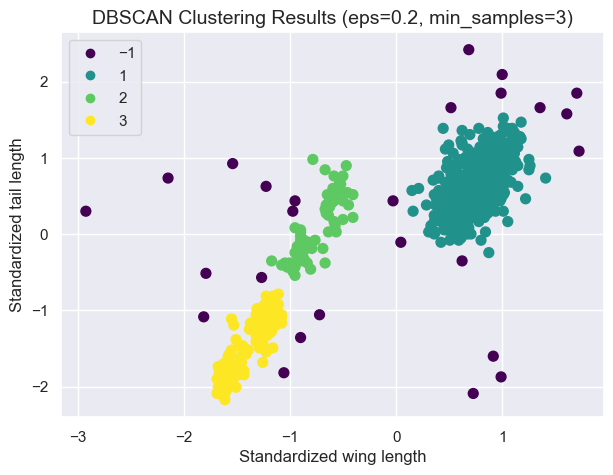

In [25]:
my_dbscan.plot_clusters()
plt.xlabel("Standardized wing length")
plt.ylabel("Standardized tail length")
plt.show()

The plot using my custom DBSCAN class looks the same as the plot from the scikit-learn DBSCAN using the same hyperparameters!

The clusters in the hawks data have been identified; DBSCAN was able to discern the different species and identify potential outlier/noise points. My custom class also gave me more insight into the behind-the-scenes as well.